# CNN in image classification

In [1]:
'''
Environment: 
Ubuntu 18LTS 1080Ti

Package version: 
Python3.6, keras2.1.6, backend is tensorflow-gpu 1.8.0
numpy 1.14.2, matplotlib 2.1.2 
'''
import keras
import os
import numpy as np
import pandas as pd
import matplotlib.image as mpimg
from keras.models import Model
from keras.layers import Dense, Dropout, Flatten, Input, AveragePooling2D, merge, Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization,AveragePooling2D,Dropout
from keras.layers import Concatenate, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
import matplotlib.pyplot as plt
import pydot
%matplotlib inline

/usr/local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [60]:
# Hyperparameters
splitindex = int(42000 * 0.8)
epochs = 80
lr = 0.0005
dropout_rate_1 = 0.3
dropout_rate_2 = 0.2
dropout_rate_3 = 0.1
batch_size = 256
num_classes = 62
adm = optimizers.Adam(lr=lr,decay=0.000001)

In [23]:
# Path using Ubuntu
trainDat_path = '/Users/allenzhang/Desktop/kaggle_data_set/train.csv'
# y_train_path = '/home/quanchen/Shared/train.txt'

# x_vali_path = '/home/quanchen/Shared/vali-set/'
# y_vali_path = '/home/quanchen/Shared/vali.txt'

## Load data to numpy array

In [71]:
dataDF = pd.read_csv(trainDat_path)

In [72]:
dataDF_features = dataDF[dataDF.columns[1:]]
dataDF_label = dataDF['label']

In [73]:
data_array = np.array(dataDF_features).reshape(42000,28,28,1)
label_onehot = keras.utils.to_categorical(dataDF_label, 10)

In [75]:
indecies = np.random.permutation(len(data_array))
train_data = data_array[indecies][:splitindex]
train_label = label_onehot[indecies][:splitindex]


vali_data = data_array[indecies][splitindex:]
vali_label = label_onehot[indecies][splitindex:]

In [77]:
del dataDF
del dataDF_features
del dataDF_label

## Cheack whether data is right after shullfering

0
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


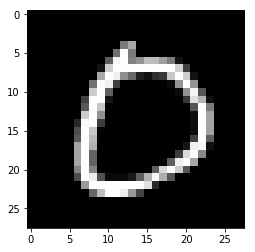

In [76]:
checkindex = 100
print(np.argmax(train_label[checkindex]))
print(train_label[checkindex])
plt.imshow(train_data[checkindex].reshape(28,28),cmap ='gray')

## Define ImageDataGenerator
This funtion will be use to rotate train image, shift their location 
accoding to width and height and zoom them in or out. 

In [78]:
# data generator with one data augmentation
datagen = ImageDataGenerator(
    #featurewise_std_normalization=True,
    rotation_range=12,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range = 0.05)

datagen.fit(train_data,augment=True,rounds=1)

## Model detail
Input --> Droupout --> Conv --> Maxpooling -->
Droupout --> Conv -->Maxpooling --> Droupout -->
Conv --> Maxpolling --> Dense --> Dense --> Dense

In [84]:
# Model detail
input = Input(shape=(28, 28, 1,))
input_dp = Dropout(0.1)(input)
conv_1 = Conv2D(32, (5,5), use_bias=True ,padding='same',activation = 'relu')(input_dp)
maxpool_1 = MaxPooling2D(pool_size=(2, 2))(conv_1)
maxpool_1_dp = Dropout(0.15)(maxpool_1)
conv_2 = Conv2D(64, (5,5), use_bias=True ,padding='same',activation = 'relu')(maxpool_1_dp)
maxpool_2 = MaxPooling2D(pool_size=(2, 2))(conv_2)
maxpool_2_dp = Dropout(0.15)(maxpool_2)
conv_3 = Conv2D(64, (5,5), use_bias=True ,padding='same',activation = 'relu')(maxpool_2_dp)
maxpool_3 = MaxPooling2D(pool_size=(2, 2))(conv_3)
# dp = Dropout(0.25)(maxpool_2)

flat_1 = Flatten()(maxpool_3)
dense_1 = Dense(1024,activation='relu',use_bias=True)(flat_1)
dense_2 = Dense(1024,activation='relu',use_bias=True)(dense_1)
output = Dense(10,activation='softmax',use_bias=True)(dense_2)

In [85]:
model = Model(inputs=[input], outputs=[output])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 28, 28, 32)        832       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 14, 14, 64)        51264     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 7, 7, 64)          0         
__________

## Compile our model

In [86]:
# determine Loss function and Optimizer
model.compile(loss='categorical_crossentropy',
              optimizer=adm,
              metrics=['accuracy'])

In [87]:
# using generator
history = model.fit_generator(datagen.flow(train_data, train_label, batch_size=batch_size),
                    steps_per_epoch=len(train_data)/batch_size,
                    epochs=epochs,validation_data=(vali_data,vali_label))

Epoch 1/200
 30/131 [=====>........................] - ETA: 1:08 - loss: 14.4588 - acc: 0.1018

KeyboardInterrupt: 

## Show the loss trend

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


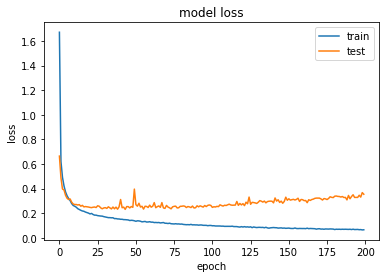

In [11]:
print(history.history.keys())

fig = plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

## Show the accuracy trend

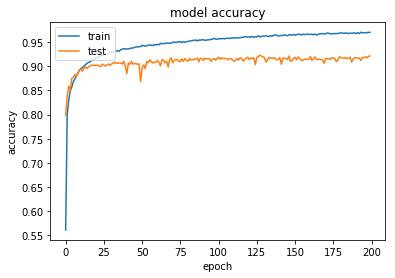

In [12]:
fig = plt.figure()
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

## Save model to local file

In [16]:
model.save('my_model-5E-5-WD-DP-E200-9213.h5') 

## Load model and show their structure

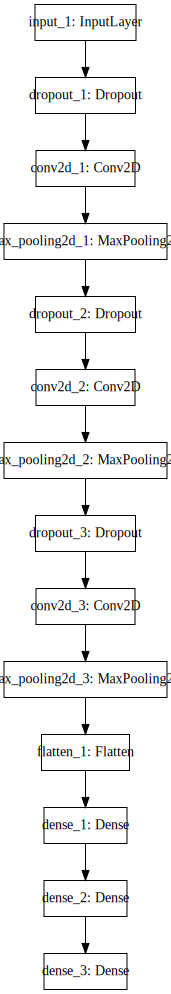

In [3]:
model = load_model('my_model-5E-5-WD-DP-E200-9213.h5')
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
SVG(model_to_dot(model).create(prog='dot', format='svg'))